In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/urban100/Urban 100/X4 Urban100/X4/HIGH x4 URban100/img_052_SRF_4_HR.png
/kaggle/input/urban100/Urban 100/X4 Urban100/X4/HIGH x4 URban100/img_050_SRF_4_HR.png
/kaggle/input/urban100/Urban 100/X4 Urban100/X4/HIGH x4 URban100/img_080_SRF_4_HR.png
/kaggle/input/urban100/Urban 100/X4 Urban100/X4/HIGH x4 URban100/img_008_SRF_4_HR.png
/kaggle/input/urban100/Urban 100/X4 Urban100/X4/HIGH x4 URban100/img_097_SRF_4_HR.png
/kaggle/input/urban100/Urban 100/X4 Urban100/X4/HIGH x4 URban100/img_041_SRF_4_HR.png
/kaggle/input/urban100/Urban 100/X4 Urban100/X4/HIGH x4 URban100/img_048_SRF_4_HR.png
/kaggle/input/urban100/Urban 100/X4 Urban100/X4/HIGH x4 URban100/img_028_SRF_4_HR.png
/kaggle/input/urban100/Urban 100/X4 Urban100/X4/HIGH x4 URban100/img_012_SRF_4_HR.png
/kaggle/input/urban100/Urban 100/X4 Urban100/X4/HIGH x4 URban100/img_039_SRF_4_HR.png
/kaggle/input/urban100/Urban 100/X4 Urban100/X4/HIGH x4 URban100/img_025_SRF_4_HR.png
/kaggle/input/urban100/Urban 100/X4 Urban100/X4/HIGH x

In [2]:
!pip install tensorflow
!pip install keras
!pip install imageio
!pip install opencv-python

In [3]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, UpSampling2D, Add, Dense, Flatten, Reshape, Activation, LeakyReLU, BatchNormalization
from tensorflow.keras.models import Model

high_res_input_dir = '/kaggle/input/urban100/Urban 100/X2 Urban100/X2/HIGH X2 Urban'  
low_res_input_dir = '/kaggle/input/urban100/Urban 100/X2 Urban100/X2/LOW X2 Urban'   

def load_images(dataset_path, size=(256, 256)):
    images = []
    for filename in os.listdir(dataset_path):
        img_path = os.path.join(dataset_path, filename)
        img = cv2.imread(img_path)

        if img is None:
            print(f"Failed to load image: {img_path}")
            continue
        
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, size)
        images.append(img)
    return np.array(images)

high_res_images = load_images(high_res_input_dir)
low_res_images = load_images(low_res_input_dir, size=(64, 64))

print(f'Loaded {len(high_res_images)} high-res and {len(low_res_images)} low-res images.')

Loaded 100 high-res and 100 low-res images.


In [4]:
def preprocess(images):
    images = np.array(images, dtype=np.float32)
    images = (images - 127.5) / 127.5
    return images

high_res_images = preprocess(high_res_images)
low_res_images = preprocess(low_res_images)

In [5]:
from tensorflow.keras.layers import Add

def residual_block(x):
    skip = x
    # First convolution
    x = Conv2D(64, kernel_size=3, padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)

    # Second convolution
    x = Conv2D(64, kernel_size=3, padding='same')(x)
    x = BatchNormalization()(x)

    # Adjust skip connection to match output shape
    skip = Conv2D(64, kernel_size=1, padding='same')(skip) 
    return Add()([x, skip])

In [6]:
from tensorflow.keras.layers import Concatenate

def inception_block(x):
    branch1 = Conv2D(32, kernel_size=1, padding='same')(x)

    branch2 = Conv2D(32, kernel_size=1, padding='same')(x)
    branch2 = Conv2D(32, kernel_size=3, padding='same')(branch2)

    branch3 = Conv2D(32, kernel_size=1, padding='same')(x)
    branch3 = Conv2D(32, kernel_size=5, padding='same')(branch3)

    branch4 = Conv2D(32, kernel_size=1, padding='same')(x)

    outputs = [branch1, branch2, branch3, branch4]
    return tf.keras.layers.concatenate(outputs)

In [7]:
from tensorflow.keras.layers import UpSampling2D

def build_generator():
    inputs = Input(shape=(64, 64, 3))
    # Initial convolutional layer
    x = Conv2D(64, kernel_size=9, padding='same')(inputs)
    x = LeakyReLU(alpha=0.2)(x)

    for _ in range(4):
        x = residual_block(x)
        x = inception_block(x)

    x = UpSampling2D(size=2)(x)
    x = Conv2D(64, kernel_size=3, padding='same')(x)
    x = Activation('relu')(x)

    x = UpSampling2D(size=2)(x)
    generated_image = Conv2D(3, kernel_size=9, padding='same')(x)

    return Model(inputs, generated_image)

In [8]:
def build_discriminator():
    inputs = Input(shape=(256, 256, 3))

    x = Conv2D(64, kernel_size=3, strides=2, padding='same')(inputs)
    x = LeakyReLU(alpha=0.2)(x)

    for _ in range(3):
        x = Conv2D(64, kernel_size=3, strides=2, padding='same')(x)
        x = LeakyReLU(alpha=0.2)(x)
        x = BatchNormalization()(x)

    x = Flatten()(x)
    x = Dense(1, activation='sigmoid')(x)

    return Model(inputs, x)

In [9]:
def build_srgan(generator, discriminator):
    discriminator.trainable = False

    inputs = Input(shape=(64, 64, 3))
    generated_image = generator(inputs)
    validity = discriminator(generated_image)

    return Model(inputs, [generated_image, validity])

generator = build_generator()
discriminator = build_discriminator()

discriminator.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
srgan = build_srgan(generator, discriminator)
srgan.compile(loss=['mse', 'binary_crossentropy'], optimizer='adam')

/opt/conda/lib/python3.10/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


In [10]:
def train_srgan(epochs, batch_size):
    for epoch in range(epochs):
        idx = np.random.randint(0, high_res_images.shape[0], batch_size)
        real_images = high_res_images[idx]
        low_images = low_res_images[idx]

        fake_images = generator.predict(low_images)

        real_labels = np.ones((batch_size, 1))
        fake_labels = np.zeros((batch_size, 1))

        d_loss_real = discriminator.train_on_batch(real_images, real_labels)
        d_loss_fake = discriminator.train_on_batch(fake_images, fake_labels)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        g_loss = srgan.train_on_batch(low_images, [real_images, real_labels])

        print(f'Epoch: {epoch+1}/{epochs}, D Loss: {d_loss[0]}, G Loss: {g_loss[0]}')

train_srgan(epochs=70, batch_size=16)

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


/opt/conda/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py:71: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


Epoch: 1/70, D Loss: 0.6877849102020264, G Loss: 0.7030930519104004
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Epoch: 2/70, D Loss: 0.6919129490852356, G Loss: 0.6891988515853882
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Epoch: 3/70, D Loss: 0.7046490907669067, G Loss: 0.7224621176719666
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Epoch: 4/70, D Loss: 0.723096489906311, G Loss: 0.731367826461792
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Epoch: 5/70, D Loss: 0.7331867814064026, G Loss: 0.7421743273735046
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Epoch: 6/70, D Loss: 0.7408204078674316, G Loss: 0.7463662028312683
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Epoch: 7/70, D Loss: 0.7433063983917236, G Loss: 0.7460599541664124
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Epoch: 8/70, D Loss: 0.7426389455795288, G Loss: 0.7445448040962219
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Epoch: 9/70, D Loss: 0.7424606084823608, G Loss: 0.7445312142372131
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Epoch: 10/70, D Loss: 0.7423371076583862, G Loss: 0.74425429105758

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


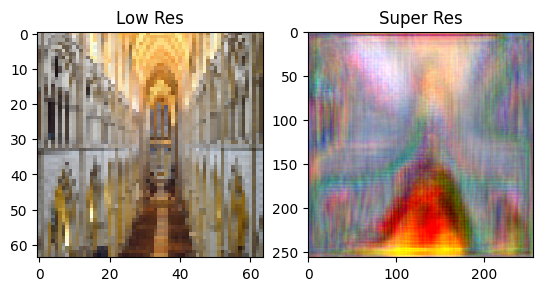

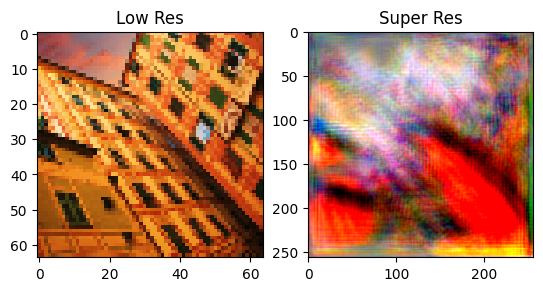

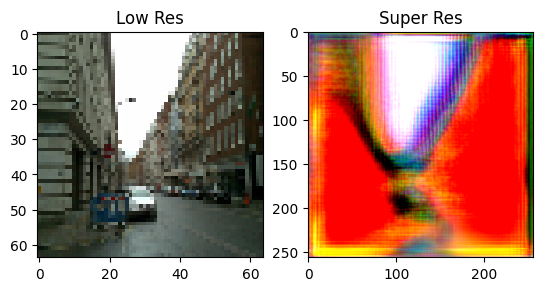

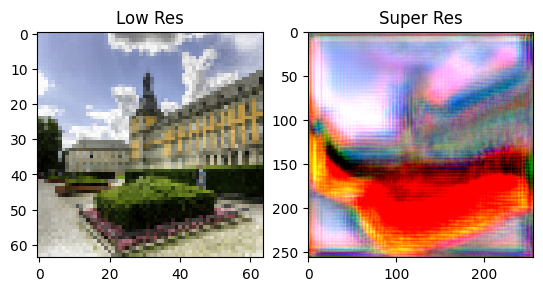

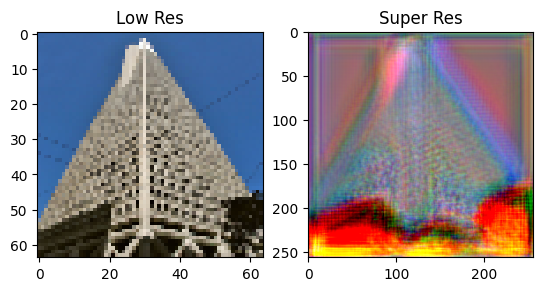

In [11]:
def upscale_images(low_res_images):
    generated_images = generator.predict(low_res_images)
    return (generated_images + 1) / 2.0  # Rescale from [-1, 1] to [0, 1]

test_images = low_res_images[:5]
upscaled_images = upscale_images(test_images)

for i in range(len(test_images)):
    plt.subplot(1, 2, 1)
    plt.imshow((test_images[i] + 1) / 2.0)
    plt.title('Low Res')

    plt.subplot(1, 2, 2)
    plt.imshow(upscaled_images[i])
    plt.title('Super Res')
    plt.show()
